In [1]:
# basic library
import pandas as pd
import numpy as np
# import re
# import string
# import os
# import seaborn as sns
import matplotlib.pyplot as plt
# from wordcloud import WordCloud

# model
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# stop words
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# stememer
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# nltk corpus
# import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

# tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

# vectorizer
# from sklearn.feature_extraction.text import TfidfVectorizer
# from gensim.models import Word2Vec
from gensim.models import FastText
from gensim.models import KeyedVectors

# other preprocessing
from tensorflow.keras.preprocessing.sequence import pad_sequences

# training pipline
import tensorflow as tf
import numpy as np
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# label encoding
label_type = ['NotPromotion', 'Promotion']

In [2]:
# %load_ext cudf.pandas

# %pip install seaborn
# %pip install Sastrawi
# %pip install wordcloud
# %pip install torch
# %pip install transformers
# %pip install nltk
# %pip install tensorflow
# %pip install gensim --upgrade
# %pip install Sastrawi
# %pip install fasttext-wheel
# %pip install gensim

# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [3]:
combined_data = pd.read_csv('../Dataset/dataset_combined_new - dataset_combined_new.csv', sep=',')
training_data = pd.read_csv('../Dataset/train.csv', sep=',').dropna()
testing_data = pd.read_csv('../Dataset/test.csv', sep=',')
validation_data = pd.read_csv('../Dataset/val.csv')

# training_data = training_data.sample(frac = 1)
training_data.head()

,text,label
0,Mencari pengalaman daring yang lancar? AERO88 ...,1
1,Itu kayanya di kasih tanda deh yg bisa di lewa...,0
2,Whatsapp Telegram Livechat Daftar Login Hdtoto...,1
3,KO SELASA SI BABG,0
4,"TERLEPAS DARI GAME NYA YANG BAGUS, SEMOGA BANG...",0


In [4]:
print("train isna:",training_data['text'].isna().sum())
print("test isna:",testing_data['text'].isna().sum())
print("val isna:",validation_data['text'].isna().sum())

print(training_data[training_data['text'].isna()][['text', 'label']])


train isna: 0
test isna: 0
val isna: 0
Empty DataFrame
Columns: [text, label]
Index: []


# Preprocessing

In [5]:
stop_factory = StopWordRemoverFactory()
sastrawi_stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu']
drop_stopwords = ['pula', 'pasti', 'amat', 'ingin', 'sampai']

sastrawi_stopwords += custom_stopwords
sastrawi_stopwords = [word for word in sastrawi_stopwords if word not in drop_stopwords]

pattern = r"[^A-Za-z ]"

print(stopwords)

<WordListCorpusReader in 'C:\\Users\\tyogo\\AppData\\Roaming\\nltk_data\\corpora\\stopwords'>


In [6]:
def preprocess_text(texts):
    sentences=[]
    for index, text in enumerate(texts):

        word_list = word_tokenize(text)
        word_list = [word for word in word_list if word not in sastrawi_stopwords]
        
        text = ' '.join(word_list)
        texts[index] = text
        sentences.append(word_list)
    return texts, sentences

In [7]:
texts_raw_train = training_data['text'].values.copy()
texts_raw_val = validation_data['text'].values.copy()
texts_raw_test = testing_data['text'].values.copy()
y_train = training_data['label'].values.copy()
y_val = validation_data['label'].values.copy()
y_test = testing_data['label'].values.copy()

In [8]:
texts_train,sentences = preprocess_text(texts_raw_train)
texts_val,_ = preprocess_text(texts_raw_val)
texts_test,_ = preprocess_text(texts_raw_test)

texts_train

array(['Mencari pengalaman daring lancar ? AERO88 mungkin solusinya .',
       'Itu kayanya kasih tanda deh lewatin apa ngga , contohnya kerucut+tong sampah biru',
       'Whatsapp Telegram Livechat Daftar Login Hdtoto Beranda Slot Online Live Casino Sportsbook Arcade Togel Poker slider Jackpot Daily Wins Gates of Olympus Bonanza Gold < Starlight Princess Sweet power thor megaways Treasure Wild Aztec Gems Gatot Kaca Popular Games bowl Mahjong Ways Break Away Lucky Wilds Koi Gate 1000 Wishes Gem Saviour Conquest Chronicles X Up Gold Blitz Elven Roma Silverback Multiplier Mountain Fiery Sevens Hot Phoenix Rises Neko Fortune Tiger garuda Treasures Bandito fireworks Dreams Macau Rooster Rumble > Platform Hiburan Terbaru No.1 Indonesia Penyedia pragmatic pgsoft habanero cq9 spadegaming ttg joker microgaming ion sexy gaming allbet idnlive saba sports Metode Pembayaran Transfer Bank Pulsa E-Money ©2024 Hdtoto . All rights reserved | 18+',
       ..., 'Kerennn',
       'Saya merekomendasikan ρ

# Tokenization & Vectorizer

In [9]:
# Define parameters

EMBEDDING_DIM = 256
MAX_LEN = 128

## Torch Tokenization

In [10]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts_train)

train_texts_seq = tokenizer.texts_to_sequences(texts_train)
val_texts_seq = tokenizer.texts_to_sequences(texts_val)
test_texts_seq = tokenizer.texts_to_sequences(texts_test)

train_texts_padded = pad_sequences(train_texts_seq, maxlen=MAX_LEN, padding='post', truncating='post')
val_texts_padded = pad_sequences(val_texts_seq, maxlen=MAX_LEN, padding='post', truncating='post')
test_texts_padded = pad_sequences(test_texts_seq, maxlen=MAX_LEN, padding='post', truncating='post')

In [11]:
train_texts_padded.shape

(2736, 128)

In [12]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
VOCAB_SIZE

11021

## FastText Vectorizer 

In [ ]:
# FastText model training
fasttext_model = FastText(vector_size=EMBEDDING_DIM, alpha=0.025, window=5, min_count=1, workers=8)
fasttext_model.build_vocab(sentences)
fasttext_model.train(sentences, total_examples=len(sentences), epochs=20)
fasttext_model.save("../Tokenizer/FastText_file_200.bin")

In [49]:
fasttext_model=FastText.load("../Tokenizer/FastText_file_200.bin")

In [50]:
fasttext_model.estimate_memory()

{'vocab': 7205000,
 'syn0_vocab': 14755840,
 'syn1neg': 14755840,
 'syn0_ngrams': 2048000000,
 'buckets_word': 2705460,
 'total': 2087422140}

In [51]:
fasttext_model.wv['pulau']

array([ 0.08764438,  0.13357237,  0.36153823,  0.21334004,  0.27035895,
       -0.01942429,  0.10469425,  0.36950618,  0.04714187,  0.16026436,
       -0.28577223, -0.15626153, -0.44312555, -0.0038459 ,  0.07074919,
       -0.19263802, -0.13339278,  0.13218221,  0.16322884,  0.3930914 ,
        0.49281454,  0.50906163,  0.00466173, -0.10728167, -0.262589  ,
        0.23937151, -0.11575162, -0.06904475,  0.21872848,  0.09122016,
       -0.20492652, -0.03607909, -0.17088486, -0.24081269, -0.02428227,
       -0.41046435, -0.22521384,  0.078697  ,  0.2758642 ,  0.16317654,
        0.0105775 ,  0.1435862 ,  0.30949244,  0.01698714,  0.13428484,
       -0.11727535,  0.14914806,  0.0176801 , -0.02562221,  0.08418462,
       -0.2521921 , -0.13988127,  0.02971444,  0.18447858, -0.00874791,
        0.36563402,  0.5698087 , -0.4604412 , -0.01390122,  0.09468068,
        0.40704313,  0.39595833, -0.06470343,  0.2887663 ,  0.34294397,
        0.31978115,  0.11478715, -0.13111149, -0.12965454, -0.13

In [52]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = fasttext_model.wv[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        print(f"Word '{word}' not found in FastText model")
        continue

# Training

In [41]:
# LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Embedding, Dropout, GlobalAveragePooling1D, Flatten, SpatialDropout1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

drop_value = 0.2
# n_dense = 24

In [42]:
model = Sequential()

model.add(Embedding(
    input_dim=VOCAB_SIZE, 
    output_dim=EMBEDDING_DIM, 
    weights=[embedding_matrix], 
    trainable=False
    ))
# model.add(GlobalAveragePooling1D())
model.add(SpatialDropout1D(drop_value))

model.add(Bidirectional(LSTM(64, return_sequences=True)))
model.add(Dropout(0.3))

model.add(LSTM(32, return_sequences=True))
model.add(Dropout(0.3))

# model.add(GlobalAveragePooling1D())
model.add(Flatten())

# Fully connected layers
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
# model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     2,821,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ ?                      │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,821,376 (10.76 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,821,376 (10.76 MB)

None


In [43]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.685027541311968, 1: 1.851150202976996}

In [44]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights = dict(enumerate(class_weights))

checkpoint_callback = ModelCheckpoint(filepath='./best_model_checkpoint.keras',  
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      save_weights_only=False,  # Save full model (architecture + weights)
                                      verbose=1)
# early_stop = EarlyStopping(monitor='val_loss', patience=3)

num_epochs = 100
history = model.fit(
    train_texts_padded,
    y_train,
    validation_data=(val_texts_padded,y_val),
    epochs=num_epochs,
    callbacks=[checkpoint_callback],
    class_weight=class_weights
)


Epoch 1/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.4328 - loss: 1.3073
Epoch 1: val_accuracy improved from -inf to 0.72886, saving model to ./best_model_checkpoint.keras
86/86 ━━━━━━━━━━━━━━━━━━━━ 27s 211ms/step - accuracy: 0.4344 - loss: 1.3071 - val_accuracy: 0.7289 - val_loss: 1.2495
Epoch 2/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.3241 - loss: 1.2339
Epoch 2: val_accuracy did not improve from 0.72886
86/86 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 0.3236 - loss: 1.2337 - val_accuracy: 0.2711 - val_loss: 1.1780
Epoch 3/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.4286 - loss: 1.1547
Epoch 3: val_accuracy did not improve from 0.72886
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 121ms/step - accuracy: 0.4297 - loss: 1.1547 - val_accuracy: 0.2711 - val_loss: 1.1151
Epoch 4/100
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.2786 - loss: 1.0952
Epoch 4: val_accuracy did not improve from 0.72886
86/86 ━━━━━━━━━━━━━━━━━━━━ 10s 118ms/step - ac

In [ ]:
model.save("../Model/LSTM_FASTTEXT_TORCH_EMBEDDING_TRAINABLEFALSE.h5")
model.save("../Model/LSTM_FASTTEXT_TORCH_EMBEDDING_TRAINABLEFALSE.keras")

# Eval

In [13]:
from tensorflow.keras.models import load_model

model = load_model("../Model/LSTM_FASTTEXT_TORCH_EMBEDDING_TRAINABLEFALSE.keras")

c:\Users\tyogo\.conda\envs\nlp\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 15 variables whereas the saved optimizer has 28 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [14]:
model.evaluate(test_texts_padded, y_test, verbose=0)


[0.21609506011009216, 0.932748556137085]

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
# plt.ylim([0, 0.2])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.title("Loss History")
plt.show()

plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.title("Accuracy History")
plt.grid(True)

c:\Users\tyogo\.conda\envs\nlp\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=('Tensor(shape=(32, 128))', 'Tensor(shape=(32,))')
  warnings.warn(msg)


 9/11 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step

c:\Users\tyogo\.conda\envs\nlp\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=('Tensor(shape=(None, 128))', 'Tensor(shape=(None,))')
  warnings.warn(msg)


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step
Accuracy Score: 0.9327485380116959
F1 Score: 0.8729281767955801
Recall Score: 0.8876404494382022
Precision Score: 0.8586956521739131
Classification Report: 
              precision    recall  f1-score   support

NotPromotion       0.95      0.96      0.95       250
   Promotion       0.89      0.86      0.87        92

    accuracy                           0.93       342
   macro avg       0.92      0.91      0.91       342
weighted avg       0.93      0.93      0.93       342

Confusion Matrix:



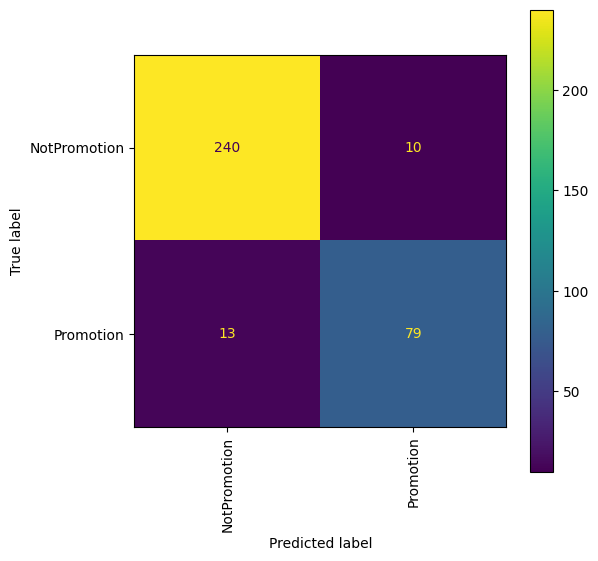

In [16]:
pred = model.predict((test_texts_padded, y_test))
y_pred = [0 if pred < 0.5 else 1 for pred in pred]

print(f"Accuracy Score: {accuracy_score(y_pred, y_test)}")
print(f"F1 Score: {f1_score(y_pred, y_test)}")
print(f"Recall Score: {recall_score(y_pred, y_test)}")
print(f"Precision Score: {precision_score(y_pred, y_test)}")
print(f"Classification Report: \n{classification_report(y_test, y_pred, target_names=label_type)}")

display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = label_type)

fig, ax = plt.subplots(figsize=(6,6))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')
plt.show()

In [98]:
for idx,i in enumerate(y_pred):
    if i != y_test[idx]:
        print(idx+1,")❌pred:", i, "| label:", y_test[idx], texts_test[idx])
        continue
    print(idx+1,") pred:", i, "| label:", y_test[idx], texts_test[idx])

1 ) pred: 1 | label: 1 INFO CINA777APK CINA777RTP CINA777Logo24/11/2024 ( Min ) 14.56 ( GMT+07 ) Versi MobileVersi WAP ( NEX4D ) Nama PenggunaKata SandiLupa Kata Sandi ? DaftarHomeTogelHot GamesSlotsLive CasinoOlahragaCrash GameArcadePokerE-SportsSabung AyamPromosiWelcome to situs resmi CINA777 | Kami membayar berapapun kemenangan player.HasilPasaranBuku MimpiHasil TerakhirStatistik MarketGame PopulerMahjong Wins 3 – Black ScatterMAINMahjong Wins 3 – Black ScatterMahjong WaysMAINMahjong WaysMighty HerculesMAINMighty HerculesSlot88 BonanzaMAINSlot88 BonanzaLe PharaohMAINLe PharaohPirate Quest 1000MAINPirate Quest 1000SixSixSixMAINSixSixSixWay of NinjaMAINWay of Ninja888 GoldMAIN888 GoldMahjong Ways 2MAINMahjong Ways 2Gates of Olympus 1000™MAINGates of Olympus 1000™Wild Bounty ShowdownMAINWild Bounty ShowdownLucky Twins NexusMAINLucky Twins NexusNexus Koi GateMAINNexus Koi GateThe CryptMAINThe CryptLucky Twins Power ClustersMAINLucky Twins Power ClustersMentalMAINMentalFortune Gems 2MAIN

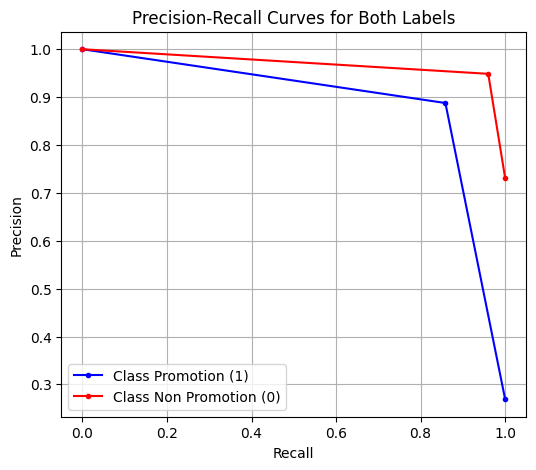

In [ ]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall values for class 1 (positive class)
precision_1, recall_1, _ = precision_recall_curve(y_test, y_pred)

# Compute precision-recall values for class 0 (negative class)
y_scores_neg = 1 - np.array(y_pred)  # Since model predicts class 1 probabilities, class 0 is (1 - probability)
precision_0, recall_0, _ = precision_recall_curve(1 - y_test, y_scores_neg)

# Plot Precision-Recall curves for both classes
plt.figure(figsize=(6, 5))
plt.plot(recall_1, precision_1, marker='.', label=f'Class Promotion (1)', color='blue')
plt.plot(recall_0, precision_0, marker='.', label=f'Class Non Promotion (0)', color='red')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for Both Labels')
plt.legend()
plt.grid()
plt.show()

ROC AUC Score: 0.9692


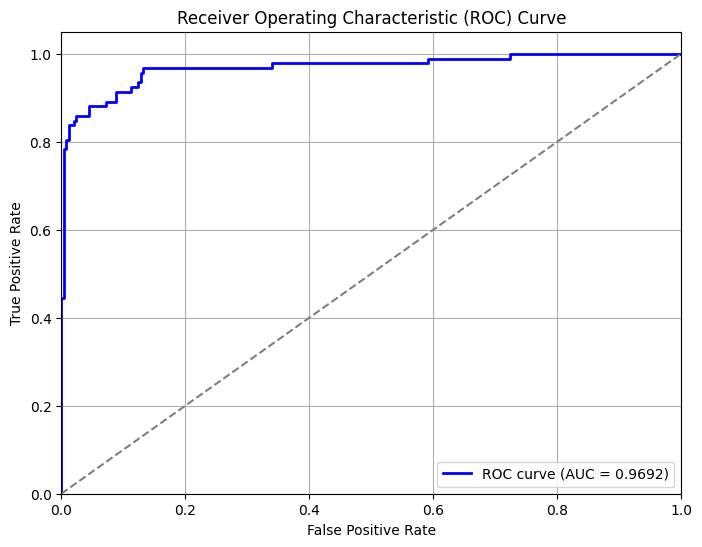

In [86]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Calculate ROC AUC score
auc_score = roc_auc_score(y_test, pred)
print(f"ROC AUC Score: {auc_score:.4f}")

# Plot ROC curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, pred)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
def predict_sentiment(text):
    use_text,_ = preprocess_text(text)
    # inputs = tokenizer(use_text, padding=True, truncation=True, return_tensors='tf', max_length=512)
    use_text = tokenizer.texts_to_sequences(use_text)
    use_text = pad_sequences(use_text, maxlen=MAX_LEN, padding='post', truncating='post')

    pred = model.predict(use_text)
    # pred_labels = tf.argmax(pred, axis=1)
    pred_labels = [0 if pred < 0.5 else 1 for pred in pred]
    # print(pred)
 
    pred_labels = [label_type[label] for label in pred_labels]
    for index, preds in enumerate(pred_labels):
        print(f"{text[index]}: {preds}")
text = [
    "Aku adalah seorang mahasiswa",
    "Judi Online Disebut Masuk Tahap Sosial, Cak Imin: 8,8 Juta Pasien Minta Direhabilitasi Jumat, 15 Nov",
    "Gacor xxtoto menang pasti dibayar",
    "dp jd jt buruan gas garansi meteorwin",
    "gacor pasti menang di xxtoto",
    "top up di kantorbola pasti gampang menangnya",
    "gratis koin buruan topup di agencasinoindonesia",
    "gratis koin buruan topup di fairbet88.com, segera daftarkan akun anda",
    "DEWA-DORA tuh situs yang paling enak withdraw tiap hari! 😖 😣",
    "DEWA-DORA tuh situs    yang paling gampang narik tiap hari! 😖 😣",
    "Gua setia maen di DEWADORA, tempat terbaik!",
    "kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung dan Menang berapapun dibayar.",
    "dapatkan banyak rejekii di DEWADORА!"
]
predict_sentiment(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
Aku seorang mahasiswa: NotPromotion
Judi Online Disebut Masuk Tahap Sosial , Cak Imin : 8,8 Juta Pasien Minta Direhabilitasi Jumat , 15 Nov: Promotion
Gacor xxtoto menang pasti dibayar: Promotion
dp jd jt buruan gas garansi meteorwin: NotPromotion
gacor pasti menang xxtoto: Promotion
top up kantorbola pasti gampang menangnya: Promotion
gratis koin buruan topup agencasinoindonesia: NotPromotion
gratis koin buruan topup fairbet88.com , segera daftarkan akun: Promotion
DEWA-DORA tuh situs paling enak withdraw tiap hari ! 😖 😣: Promotion
DEWA-DORA tuh situs paling gampang narik tiap hari ! 😖 😣: Promotion
Gua setia maen DEWADORA , tempat terbaik !: Promotion
kantorbola99.club - Mau Jackpot x50 x100 x500 x1000 pasti dibayar ? gabung Menang berapapun dibayar .: Promotion
dapatkan banyak rejekii DEWADORА !: NotPromotion
